In [1]:
import time
from datetime import datetime
import requests
import json
import os

import networkx as nx
import numpy as np
import json
import random
import math

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip, slow_reversible_propose
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part, random_spanning_tree,PopulatedGraph
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, partisan_bias
import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

from gerrychain.updaters import cut_edges

from gerrychain.tree import bipartition_tree, find_balanced_edge_cuts_memoization

from gerrychain.updaters import num_spanning_trees

from functools import partial

import geopandas as gpd
import pandas as pd

from networkx.readwrite import json_graph



In [2]:
"""
url = f"https://raw.githubusercontent.com/eveomett-states/SouthCarolina/refs/heads/main/sc.json"
        
r = requests.get(url)
data = r.json()
graph = Graph(json_graph.adjacency_graph(data))
"""

graph = Graph.from_json("./SC_Processed_Precincts.json")


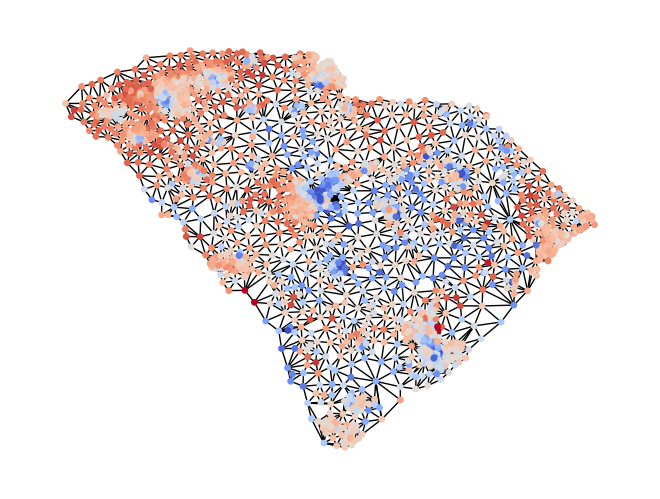

In [3]:
nx.draw(graph,pos={n:(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()},node_size=15,node_color= [graph.nodes[n]["G20PREDBID"]/(graph.nodes[n]["G20PREDBID"]+graph.nodes[n]["G20PRERTRU"] +1 ) for n in graph.nodes()],cmap='coolwarm_r')


In [4]:
totpop = 0

for node in graph.nodes():
    totpop += graph.nodes[node]['population']

In [5]:
new_part = recursive_tree_part(graph,range(7),totpop/7,"population",.02)

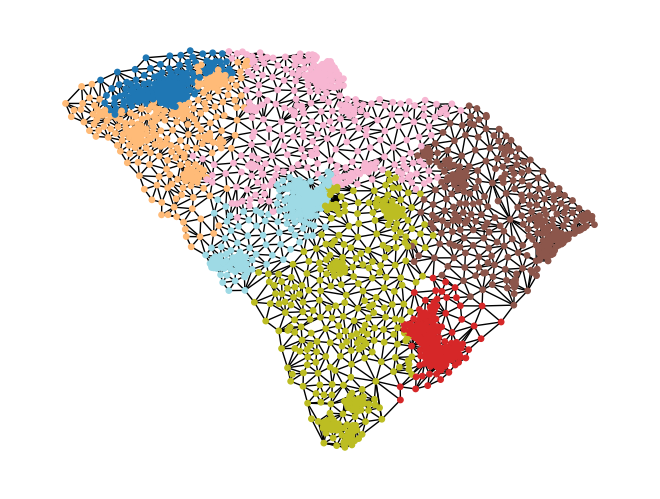

In [6]:
nx.draw(graph,pos={n:(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()},node_size=15,node_color= [new_part[n] for n in graph.nodes()],cmap='tab20')


In [7]:
for i in range(100):

    current_seed = recursive_tree_part(graph,range(7),totpop/7,"population",.02)
    
    with open(f'./seed_dicts/SC_CON_seed{i}.json', 'w') as fp:
        json.dump(current_seed, fp)

In [8]:
my_updaters = {
    "population": updaters.Tally("population", alias="population"),
    "cut_edges": cut_edges,
    "PP":polsby_popper,
}


num_elections = 2



election_names = [
    "PRES",
    "USS",
]

election_columns = [
    ["G20PREDBID", "G20PRERTRU"],
    ["G20USSDHAR", "G20USSRGRA"],
]


elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)


In [9]:
first_partition = Partition(graph,new_part,my_updaters)

In [10]:
recom_proposal = partial(recom,
                      pop_col='population',
                      pop_target=totpop/7,
                      epsilon=.05)

In [11]:
recom_chain = MarkovChain(
    proposal=recom_proposal,#slow_reversible_propose,#propose_random_flip,
    constraints=[
        #multi_pop_constraint
    ],
    accept=accept.always_accept,#recom_tree_accept,#annealing_tree_accept2,#MH_CE,#C
    initial_state=first_partition,#first_partition,
    total_steps=1000
  )




In [13]:
for step, part in enumerate(recom_chain):

    ad = dict(part.assignment)
    with open(f'./markov_steps/SC_CON_seed{step}.json', 'w') as fp:
        json.dump(ad, fp)

    
    

In [22]:
with open(f'./seed_dicts/SC_CON_seed{i}.json', 'r') as file:
            
    current_seed = json.load(file)
    
    #current_seed = {int(x):current_seed[x] for x in current_seed.keys()}

current_part = GeographicPartition(graph,current_seed,my_updaters)



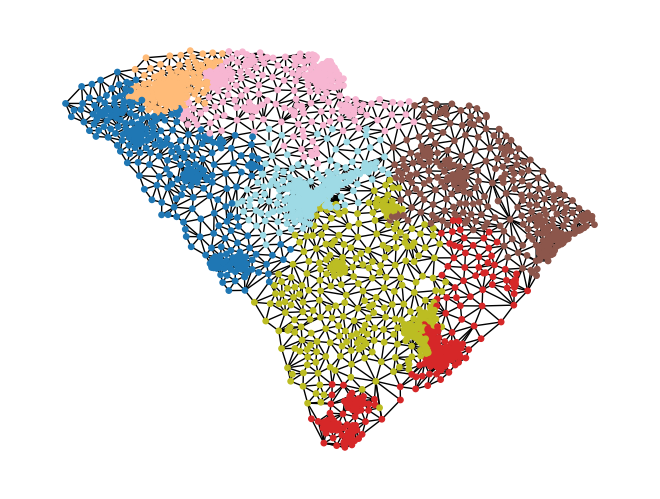

In [26]:
nx.draw(graph,pos={n:(graph.nodes[n]["C_X"],graph.nodes[n]["C_Y"]) for n in graph.nodes()},node_size=15,node_color= [current_seed[n] for n in graph.nodes()],cmap='tab20')


In [27]:
reverse_dict = dict()

for node in graph.nodes():
    if current_seed[node] in reverse_dict.keys():
        reverse_dict[current_seed[node]].append(node)
    else: 
        reverse_dict[current_seed[node]] = []

In [28]:
current_part['area']
current_part['perimeter']

{0: 10.22473990160033,
 1: 4.171912477933823,
 2: 10.682358640391394,
 3: 7.979799471796972,
 4: 9.24995058783675,
 5: 12.366281923711242,
 6: 8.529476418216245}